# Model Testing for Daily Fantasy Scores
Predict for the minimum and maximum winning scores for a slate

In [1]:
import logging

FORMAT = '%(asctime)-15s :: %(message)s'
logging.basicConfig(format=FORMAT)
LOGGER = logging.getLogger('dfscore')
LOGGER.setLevel(logging.INFO)
LOGGER.info("logger ready")

2022-06-22 02:05:55,518 :: logger ready


In [2]:
from generate_train_test import generate_train_test, load_csv
from automl import create_automl_model, error_report


def evaluate_models(sport, service, style, contest_type, framework, automl_params,
                    pca_components=5, seed=0): 
    """
    evaluate and return 6 models
    for the top score and last winning score evaluate 
    1) a standard model using all features, 
    2) a pca model that reduces the features to pca_components components
    3) a model based on best score
    """
    models = {}
    df = load_csv(sport, service, style, contest_type)
    # with pd.option_context('max_rows', 1000, 'max_columns', 100):
    #     LOGGER.info(f"{len(df)} rows")
    # display(df)        

    # generate 6 models, top and last winning score models 
    # using 1) all data columns, 2) pca reduction of all data and 3) just the best possible score
    for model_cols in [None, {'best-possible-score'}]:
        model_data = generate_train_test(
            df,
            model_cols=model_cols,
            random_state=seed,
        )
        
        if model_data is None or len(model_data[0]) < 5:
            LOGGER.error("Not enough training data available!")
            return
            
        (X_train, X_test, y_top_train, y_top_test,
         y_last_win_train, y_last_win_test) = model_data
        
        model_ys = [
            ('top-score', y_top_train, y_top_test), 
            ('last-win-score', y_last_win_train, y_last_win_test), 
        ]
        # models for top and last winning score
        for model_name, y_train, y_test in model_ys:
            LOGGER.info(f"training {model_name=} {model_cols=}")
            model, fit_params = create_automl_model(
                model_name, 
                seed=seed,
                framework=framework,
                **automl_params
            )
            model.fit(X_train, y_train, **fit_params)
            model_desc = f"{sport}-{service}-{style.name}-{contest_type.NAME}-{model_name}-{framework}: {model_cols=}"
            error_report(model, X_test, y_test, model_desc)
            models[model_desc] = model
            
        # pca models only when using multiple data columns
        if model_cols is not None and len(model_cols) == 1:
            return
                
        for model_name, y_train, y_test in model_ys:
            model_name += '-pca'
            LOGGER.info(f"training {model_name=} {model_cols=}")
            model, fit_params = create_automl_model(
                model_name,
                pca_components=pca_components,
                seed=RANDOM_SEED,
                framework=framework,
                **automl_params
            )
            model.fit(X_train, y_train, **fit_params)
            model_desc = f"{sport}-{service}-{style.name}-{contest_type.NAME}-{model_name}-{framework}: {model_cols=}"
            error_report(model, X_test, y_test, model_desc)
            models[model_desc] = model
            
    return models


def multi_run(model_params: dict, styles, sports, services, contest_types, seed):
    LOGGER.info("starting multirun")
    models = {}
    for framework, params in model_params.items(): 
        for sport in sports:
            for service in services:
                for style in styles:
                    for contest_type in contest_types:
                        try:
                            new_models = evaluate_models(sport, service, style, contest_type, framework, params, seed=seed)
                            if new_models is None:
                                LOGGER.warning("No models generated for %s-%s-%s-%s", 
                                            sport, service, style.name, contest_type.NAME)
                            else: 
                                models.update(new_models)
                        except FileNotFoundError as ex:
                            LOGGER.error("Data file required for modelling not found", exc_info=ex)
    LOGGER.info("finished multirun")
    return models

/venv/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


/venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2022-06-22 02:06:01-INFO-dfscore(77)-starting multirun
loading filename='nhl-fanduel-CLASSIC-FIFTY_FIFTY.csv'
178 rows of data loaded
dropping 72 rows due to nan_slate_rows=1 nan_best_score_rows=71
2022-06-22 02:06:01-ERROR-dfscore(30)-Not enough training data available!
2022-06-22 02:06:01-WARNING-dfscore(87)-No models generated for nhl-fanduel-CLASSIC-FIFTY_FIFTY
loading filename='nhl-fanduel-CLASSIC-GPP.csv'
433 rows of data loaded
dropping 179 rows due to nan_slate_rows=2 nan_best_score_rows=177
2022-06-22 02:06:01-ERROR-dfscore(30)-Not enough training data available!
2022-06-22 02:06:01-WARNING-dfscore(87)-No models generated for nhl-fanduel-CLASSIC-GPP
loading filename='nhl-fanduel-SHOWDOWN-FIFTY_FIFTY.csv'
3 rows of data loaded
2022-06-22 02:06:01-ERROR-dfscore(30)-Not enough training data available!
2022-06-22 02:06:01-WARNING-dfscore(87)-No models generated for nhl-fanduel-SHOWDOWN-FIFTY_FIFTY
loading filename='nhl-fanduel-SHOWDOWN-GPP.csv'
2022-06-22 02:06:01-ERROR-dfscore(92

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]

/venv/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/venv/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/venv/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/venv/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warni


Generation 1 - Current best internal CV score: -297.50417599995944

Generation 2 - Current best internal CV score: -296.9958876612564

Generation 3 - Current best internal CV score: -292.73907954989613

Generation 4 - Current best internal CV score: -290.0235850701763

Generation 5 - Current best internal CV score: -290.0235850701763

Generation 6 - Current best internal CV score: -290.0235850701763

Generation 7 - Current best internal CV score: -290.0235850701763

Generation 8 - Current best internal CV score: -290.0235850701763

Generation 9 - Current best internal CV score: -288.92406100073816

Generation 10 - Current best internal CV score: -285.6523011648131

Generation 11 - Current best internal CV score: -285.6523011648131

Generation 12 - Current best internal CV score: -282.9967098706324

Generation 13 - Current best internal CV score: -282.9967098706324

Generation 14 - Current best internal CV score: -282.99158035301707

Generation 15 - Current best internal CV score: -280

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -205.3606345478567

Generation 2 - Current best internal CV score: -205.3606345478567

Generation 3 - Current best internal CV score: -205.3606345478567

Generation 4 - Current best internal CV score: -205.3606345478567

Generation 5 - Current best internal CV score: -205.3606345478567

Generation 6 - Current best internal CV score: -205.3606345478567

Generation 7 - Current best internal CV score: -205.3606345478567

Generation 8 - Current best internal CV score: -205.3606345478567

Generation 9 - Current best internal CV score: -180.75411417181002

Generation 10 - Current best internal CV score: -180.75411417181002

Generation 11 - Current best internal CV score: -180.75411417181002

Generation 12 - Current best internal CV score: -180.75411417181002

Generation 13 - Current best internal CV score: -180.75411417181002

Generation 14 - Current best internal CV score: -180.75411417181002

Generation 15 - Current best internal CV score: -1

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -341.2767099418429

Generation 2 - Current best internal CV score: -326.42028936149154

Generation 3 - Current best internal CV score: -326.42028936149154

Generation 4 - Current best internal CV score: -326.1236212011523

Generation 5 - Current best internal CV score: -326.1236212011523

Generation 6 - Current best internal CV score: -326.1236212011523

Generation 7 - Current best internal CV score: -326.1236212011523

Generation 8 - Current best internal CV score: -326.06933446091483

Generation 9 - Current best internal CV score: -326.06933446091483

Generation 10 - Current best internal CV score: -325.74077363759505

Generation 11 - Current best internal CV score: -320.1349420961041

Generation 12 - Current best internal CV score: -320.1349420961041

Generation 13 - Current best internal CV score: -320.1349420961041

Generation 14 - Current best internal CV score: -320.1349420961041

Generation 15 - Current best internal CV score: -32

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -207.39509107557774

Generation 2 - Current best internal CV score: -207.39509107557774

Generation 3 - Current best internal CV score: -207.39509107557774

Generation 4 - Current best internal CV score: -200.78129348311808

Generation 5 - Current best internal CV score: -191.82874073183234

Generation 6 - Current best internal CV score: -178.98009191391748

Generation 7 - Current best internal CV score: -178.98009191391748

Generation 8 - Current best internal CV score: -178.98009191391748

Generation 9 - Current best internal CV score: -178.98009191391748

Generation 10 - Current best internal CV score: -174.1051650180419

Generation 11 - Current best internal CV score: -174.1051650180419

Generation 12 - Current best internal CV score: -174.1051650180419

Generation 13 - Current best internal CV score: -172.38695626781487

Generation 14 - Current best internal CV score: -161.88375477531832

Generation 15 - Current best internal CV scor

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -333.10388083945224

Generation 2 - Current best internal CV score: -314.67258243374954

Generation 3 - Current best internal CV score: -314.67258243374954

Generation 4 - Current best internal CV score: -314.67258243374954

Generation 5 - Current best internal CV score: -314.67258243374954

Generation 6 - Current best internal CV score: -304.17913866290417

Generation 7 - Current best internal CV score: -304.17913866290417

Generation 8 - Current best internal CV score: -304.17913866290417

Generation 9 - Current best internal CV score: -299.9673711651423

Generation 10 - Current best internal CV score: -296.21193538143444

Generation 11 - Current best internal CV score: -296.21193538143444

Generation 12 - Current best internal CV score: -296.21193538143444

Generation 13 - Current best internal CV score: -296.21193538143444

Generation 14 - Current best internal CV score: -293.9443656793799

Generation 15 - Current best internal CV sco

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -220.2759976056008

Generation 2 - Current best internal CV score: -220.2759976056008

Generation 3 - Current best internal CV score: -218.95219964262873

Generation 4 - Current best internal CV score: -218.95219964262873

Generation 5 - Current best internal CV score: -211.07139084961636

Generation 6 - Current best internal CV score: -211.07139084961636

Generation 7 - Current best internal CV score: -210.49109612307498

Generation 8 - Current best internal CV score: -205.0644063632539

Generation 9 - Current best internal CV score: -200.66135799793682

Generation 10 - Current best internal CV score: -190.10347124001296

Generation 11 - Current best internal CV score: -190.10347124001296

Generation 12 - Current best internal CV score: -190.10347124001296

Generation 13 - Current best internal CV score: -190.10347124001296

Generation 14 - Current best internal CV score: -184.27174334026887

Generation 15 - Current best internal CV scor

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -357.43759630597555

Generation 2 - Current best internal CV score: -357.43759630597555

Generation 3 - Current best internal CV score: -354.25592145549166

Generation 4 - Current best internal CV score: -354.25592145549166

Generation 5 - Current best internal CV score: -354.25592145549166

Generation 6 - Current best internal CV score: -354.25592145549166

Generation 7 - Current best internal CV score: -354.25592145549166

Generation 8 - Current best internal CV score: -351.7679077042049

Generation 9 - Current best internal CV score: -351.7679077042049

Generation 10 - Current best internal CV score: -351.7679077042049

Generation 11 - Current best internal CV score: -350.50449740600504
2022-06-22 03:49:38-WARNING-stopit(81)-Code block execution exceeded 10 seconds timeout
Traceback (most recent call last):
  File "/venv/lib/python3.10/site-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "/venv

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -397.6076107760616

Generation 2 - Current best internal CV score: -397.6076107760616

Generation 3 - Current best internal CV score: -378.7181767462807

Generation 4 - Current best internal CV score: -378.7181767462807

Generation 5 - Current best internal CV score: -336.9300497926144

Generation 6 - Current best internal CV score: -336.9300497926144

Generation 7 - Current best internal CV score: -336.9300497926144

Generation 8 - Current best internal CV score: -336.9300497926144

Generation 9 - Current best internal CV score: -336.9300497926144

Generation 10 - Current best internal CV score: -336.9300497926144

Generation 11 - Current best internal CV score: -330.3181625046837

Generation 12 - Current best internal CV score: -330.3181625046837

Generation 13 - Current best internal CV score: -330.3181625046837

Generation 14 - Current best internal CV score: -324.693195517435

Generation 15 - Current best internal CV score: -308.4675

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -390.082804407994

Generation 2 - Current best internal CV score: -380.99204738630516

Generation 3 - Current best internal CV score: -380.99204738630516

Generation 4 - Current best internal CV score: -380.99204738630516

Generation 5 - Current best internal CV score: -378.3636061035919

Generation 6 - Current best internal CV score: -377.4880065106396

Generation 7 - Current best internal CV score: -377.4880065106396

Generation 8 - Current best internal CV score: -377.43754467857804

Generation 9 - Current best internal CV score: -377.43754467851994

Generation 10 - Current best internal CV score: -377.43754467851994

Generation 11 - Current best internal CV score: -373.1812517128201

Generation 12 - Current best internal CV score: -373.1812517128201

Generation 13 - Current best internal CV score: -371.7495925256038

Generation 14 - Current best internal CV score: -371.7495925256038

Generation 15 - Current best internal CV score: -37

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -360.5137459429466

Generation 2 - Current best internal CV score: -346.91399985544507

Generation 3 - Current best internal CV score: -346.91399985544507

Generation 4 - Current best internal CV score: -346.91399985544507

Generation 5 - Current best internal CV score: -335.2996342522017

Generation 6 - Current best internal CV score: -335.2996342522017

Generation 7 - Current best internal CV score: -335.2996342522017

Generation 8 - Current best internal CV score: -328.3973224095152

Generation 9 - Current best internal CV score: -328.3973224095152

Generation 10 - Current best internal CV score: -328.3973224095152

Generation 11 - Current best internal CV score: -328.3973224095152

Generation 12 - Current best internal CV score: -328.3973224095152

Generation 13 - Current best internal CV score: -328.3973224095152

Generation 14 - Current best internal CV score: -328.3973224095152

Generation 15 - Current best internal CV score: -328.

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -450.4669497241557

Generation 2 - Current best internal CV score: -446.5733761758118

Generation 3 - Current best internal CV score: -446.5733761758118

Generation 4 - Current best internal CV score: -446.5733761758118

Generation 5 - Current best internal CV score: -443.6002557162189

Generation 6 - Current best internal CV score: -443.6002557162189

Generation 7 - Current best internal CV score: -440.8814456755248

Generation 8 - Current best internal CV score: -440.24523393653925

Generation 9 - Current best internal CV score: -439.038274481644

Generation 10 - Current best internal CV score: -439.038274481644

Generation 11 - Current best internal CV score: -436.7365831096471

Generation 12 - Current best internal CV score: -436.7365831096471

Generation 13 - Current best internal CV score: -436.7365831096471

Generation 14 - Current best internal CV score: -436.7365831096471

Generation 15 - Current best internal CV score: -436.7365

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -405.4671813871665

Generation 2 - Current best internal CV score: -405.4671813871665

Generation 3 - Current best internal CV score: -405.4671813871665

Generation 4 - Current best internal CV score: -403.26682194795774

Generation 5 - Current best internal CV score: -403.26682194795774

Generation 6 - Current best internal CV score: -403.26682194795774

Generation 7 - Current best internal CV score: -403.26682194795774

Generation 8 - Current best internal CV score: -403.2668219479577

Generation 9 - Current best internal CV score: -403.2668219479577

Generation 10 - Current best internal CV score: -403.2668219479577

Generation 11 - Current best internal CV score: -403.2668219479577

Generation 12 - Current best internal CV score: -403.2668219479576

Generation 13 - Current best internal CV score: -403.2668219479576

Generation 14 - Current best internal CV score: -403.26682194795757

Generation 15 - Current best internal CV score: -40

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -22.946956315333175

Generation 2 - Current best internal CV score: -15.876232348997874

Generation 3 - Current best internal CV score: -15.876232348997874

Generation 4 - Current best internal CV score: -15.876232348997874

Generation 5 - Current best internal CV score: -15.876232348997874

Generation 6 - Current best internal CV score: -15.876232348997874

Generation 7 - Current best internal CV score: -15.876232348997874

Generation 8 - Current best internal CV score: -15.876232348997874

Generation 9 - Current best internal CV score: -15.876232348997874

Generation 10 - Current best internal CV score: -15.876232348997874

Generation 11 - Current best internal CV score: -15.876232348997874

Generation 12 - Current best internal CV score: -13.427463210091293

Generation 13 - Current best internal CV score: -13.427463210091293

Generation 14 - Current best internal CV score: -13.427463210091293

Generation 15 - Current best internal CV s

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -19.404800895790068

Generation 2 - Current best internal CV score: -19.404800895790068

Generation 3 - Current best internal CV score: -19.404800895790068

Generation 4 - Current best internal CV score: -19.39343638035977

Generation 5 - Current best internal CV score: -18.412948017429436

Generation 6 - Current best internal CV score: -12.388262005333576

Generation 7 - Current best internal CV score: -12.388262005333576

Generation 8 - Current best internal CV score: -12.388262005333576

Generation 9 - Current best internal CV score: -12.388262005333576

Generation 10 - Current best internal CV score: -12.388262005333576

Generation 11 - Current best internal CV score: -12.388262005333576

Generation 12 - Current best internal CV score: -11.517917773610018

Generation 13 - Current best internal CV score: -11.517917773610018

Generation 14 - Current best internal CV score: -7.177567429998251

Generation 15 - Current best internal CV sco

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -38.20990379530928

Generation 2 - Current best internal CV score: -25.918999999999983

Generation 3 - Current best internal CV score: -25.918999999999983

Generation 4 - Current best internal CV score: -25.918999999999983

Generation 5 - Current best internal CV score: -24.423499999999926

Generation 6 - Current best internal CV score: -14.976677247492239

Generation 7 - Current best internal CV score: -13.337364715105926

Generation 8 - Current best internal CV score: -13.337364715105926

Generation 9 - Current best internal CV score: -13.004507105476929

Generation 10 - Current best internal CV score: -13.004507105476929

Generation 11 - Current best internal CV score: -13.004507105476929

Generation 12 - Current best internal CV score: -13.004507105476929

Generation 13 - Current best internal CV score: -12.966281053972253

Generation 14 - Current best internal CV score: -12.966281053972253

Generation 15 - Current best internal CV sc

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -26.027779578554515

Generation 2 - Current best internal CV score: -26.027779578554515

Generation 3 - Current best internal CV score: -26.027779578554515

Generation 4 - Current best internal CV score: -26.027779578554515

Generation 5 - Current best internal CV score: -26.027779578554515

Generation 6 - Current best internal CV score: -26.027779578554515

Generation 7 - Current best internal CV score: -25.20500000000001

Generation 8 - Current best internal CV score: -25.20500000000001

Generation 9 - Current best internal CV score: -25.199930781269323

Generation 10 - Current best internal CV score: -25.199930781269323

Generation 11 - Current best internal CV score: -25.199930781269323

Generation 12 - Current best internal CV score: -15.346963267519428

Generation 13 - Current best internal CV score: -15.346963267519428

Generation 14 - Current best internal CV score: -15.346963267519419

Generation 15 - Current best internal CV sco

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -31.599125887036287

Generation 2 - Current best internal CV score: -19.433859674543665

Generation 3 - Current best internal CV score: -19.433859674543665

Generation 4 - Current best internal CV score: -19.433859674543665

Generation 5 - Current best internal CV score: -19.433859674543665

Generation 6 - Current best internal CV score: -18.985812393691972

Generation 7 - Current best internal CV score: -18.985812393691972

Generation 8 - Current best internal CV score: -18.985812393691972

Generation 9 - Current best internal CV score: -18.985812393691972

Generation 10 - Current best internal CV score: -18.985812393691972

Generation 11 - Current best internal CV score: -18.985812393691972

Generation 12 - Current best internal CV score: -18.985812393691972

Generation 13 - Current best internal CV score: -18.985812393691972

Generation 14 - Current best internal CV score: -12.950986424704022

Generation 15 - Current best internal CV s

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -16.935983947515968

Generation 2 - Current best internal CV score: -16.935983947515968

Generation 3 - Current best internal CV score: -16.873772184244483

Generation 4 - Current best internal CV score: -16.873772184244483

Generation 5 - Current best internal CV score: -16.437632060197235

Generation 6 - Current best internal CV score: -16.437632060197235

Generation 7 - Current best internal CV score: -16.437632060197235

Generation 8 - Current best internal CV score: -16.164589608625768

Generation 9 - Current best internal CV score: -16.164589608625768

Generation 10 - Current best internal CV score: -16.164589608625768

Generation 11 - Current best internal CV score: -15.246129028841699

Generation 12 - Current best internal CV score: -15.246129028841699

Generation 13 - Current best internal CV score: -14.95913353573439

Generation 14 - Current best internal CV score: -14.95913353573439

Generation 15 - Current best internal CV sco

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -50.98633015259569

Generation 2 - Current best internal CV score: -50.98633015259569

Generation 3 - Current best internal CV score: -41.587044675741964

Generation 4 - Current best internal CV score: -38.90818059448878

Generation 5 - Current best internal CV score: -38.90818059448878

Generation 6 - Current best internal CV score: -32.24523703222333

Generation 7 - Current best internal CV score: -32.24523703222333

Generation 8 - Current best internal CV score: -32.24523703222333

Generation 9 - Current best internal CV score: -32.24523703222333

Generation 10 - Current best internal CV score: -32.24523703222333

Generation 11 - Current best internal CV score: -32.24523703222333

Generation 12 - Current best internal CV score: -32.24523703222333

Generation 13 - Current best internal CV score: -32.24523703222333

Generation 14 - Current best internal CV score: -32.24523703222333

Generation 15 - Current best internal CV score: -32.245

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -94.83641113332446

Generation 2 - Current best internal CV score: -94.83641113332438

Generation 3 - Current best internal CV score: -94.83641113332438

Generation 4 - Current best internal CV score: -94.83641113332438

Generation 5 - Current best internal CV score: -94.83641113332438

Generation 6 - Current best internal CV score: -94.83641113332438

Generation 7 - Current best internal CV score: -94.83641113332438

Generation 8 - Current best internal CV score: -94.83641113332438

Generation 9 - Current best internal CV score: -87.55348013654636

Generation 10 - Current best internal CV score: -87.55348013654636

Generation 11 - Current best internal CV score: -87.55348013654636

Generation 12 - Current best internal CV score: -87.55348013654636

Generation 13 - Current best internal CV score: -87.55348013654636

Generation 14 - Current best internal CV score: -87.55348013654633

Generation 15 - Current best internal CV score: -87.5534

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -40.45315666505851

Generation 2 - Current best internal CV score: -40.45315666505851

Generation 3 - Current best internal CV score: -40.45315666505847

Generation 4 - Current best internal CV score: -40.45315666505847

Generation 5 - Current best internal CV score: -40.45315666505847

Generation 6 - Current best internal CV score: -40.32245663496523

Generation 7 - Current best internal CV score: -40.32245663496523

Generation 8 - Current best internal CV score: -40.32245663496523

Generation 9 - Current best internal CV score: -38.44370501833693

Generation 10 - Current best internal CV score: -38.44370501833693

Generation 11 - Current best internal CV score: -38.44370501833693

Generation 12 - Current best internal CV score: -38.44370501833693

Generation 13 - Current best internal CV score: -38.44370501833693

Generation 14 - Current best internal CV score: -38.44370501833693

Generation 15 - Current best internal CV score: -38.4437

/fantasy-experiments/df-hist/automl.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,2, figsize=(10, 5))


2022-06-22 07:58:49-INFO-dfscore(60)-training model_name='last-win-score-pca' model_cols=None


Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -148.1579593264959

Generation 2 - Current best internal CV score: -148.1579593264959

Generation 3 - Current best internal CV score: -148.1579593264959

Generation 4 - Current best internal CV score: -142.51038416607284

Generation 5 - Current best internal CV score: -142.51038416607284

Generation 6 - Current best internal CV score: -142.46383560887017

Generation 7 - Current best internal CV score: -142.46383560887017

Generation 8 - Current best internal CV score: -141.79444633006227

Generation 9 - Current best internal CV score: -141.79444633006227

Generation 10 - Current best internal CV score: -141.57096855460733

Generation 11 - Current best internal CV score: -140.72941817006267

Generation 12 - Current best internal CV score: -140.72941817006267

Generation 13 - Current best internal CV score: -136.29034255594036

Generation 14 - Current best internal CV score: -136.29034255594036

Generation 15 - Current best internal CV scor

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -35.57232297018193

Generation 2 - Current best internal CV score: -35.50603165792411

Generation 3 - Current best internal CV score: -31.78835185608088

Generation 4 - Current best internal CV score: -31.78835185608088

Generation 5 - Current best internal CV score: -31.78835185608088

Generation 6 - Current best internal CV score: -31.78835185608088

Generation 7 - Current best internal CV score: -31.78835185608088

Generation 8 - Current best internal CV score: -31.78835185608088

Generation 9 - Current best internal CV score: -29.056314189711525

Generation 10 - Current best internal CV score: -29.056314189711525

Generation 11 - Current best internal CV score: -29.056314189711525

Generation 12 - Current best internal CV score: -29.056314189711525

Generation 13 - Current best internal CV score: -29.056314189711525

Generation 14 - Current best internal CV score: -29.056314189711525

Generation 15 - Current best internal CV score: -2

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -117.95502724009518

Generation 2 - Current best internal CV score: -110.39767200045351

Generation 3 - Current best internal CV score: -96.99789984569097

Generation 4 - Current best internal CV score: -96.99789984569097

Generation 5 - Current best internal CV score: -96.96156218631913

Generation 6 - Current best internal CV score: -96.96156218631913

Generation 7 - Current best internal CV score: -85.99341276847606

Generation 8 - Current best internal CV score: -81.38010981764569

Generation 9 - Current best internal CV score: -81.38010981764569

Generation 10 - Current best internal CV score: -81.38010981764555

Generation 11 - Current best internal CV score: -81.38010981764555

Generation 12 - Current best internal CV score: -81.38010981764555

Generation 13 - Current best internal CV score: -81.38010981764555

Generation 14 - Current best internal CV score: -65.08654383631946

Generation 15 - Current best internal CV score: -65.08

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -210.62678857990954

Generation 2 - Current best internal CV score: -180.61740081632692

Generation 3 - Current best internal CV score: -180.61740081632692

Generation 4 - Current best internal CV score: -180.61740081632692

Generation 5 - Current best internal CV score: -180.61740081632692

Generation 6 - Current best internal CV score: -155.95030777777805

Generation 7 - Current best internal CV score: -155.95030777777805

Generation 8 - Current best internal CV score: -147.45838781250077

Generation 9 - Current best internal CV score: -136.2901463561353

Generation 10 - Current best internal CV score: -136.2901463561353

Generation 11 - Current best internal CV score: -136.2901463561353

Generation 12 - Current best internal CV score: -136.2901463561353

Generation 13 - Current best internal CV score: -136.2901463561353

Generation 14 - Current best internal CV score: -136.2901463561353

Generation 15 - Current best internal CV score: 

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -224.04926272114704

Generation 2 - Current best internal CV score: -224.04926272114704

Generation 3 - Current best internal CV score: -217.44178840450303

Generation 4 - Current best internal CV score: -205.24765281684418

Generation 5 - Current best internal CV score: -199.52997179705213

Generation 6 - Current best internal CV score: -199.52997179705213

Generation 7 - Current best internal CV score: -184.68098445796775

Generation 8 - Current best internal CV score: -184.68098445796775

Generation 9 - Current best internal CV score: -181.4876438427866

Generation 10 - Current best internal CV score: -181.4876438427866

Generation 11 - Current best internal CV score: -165.49472860047746

Generation 12 - Current best internal CV score: -165.49472860047746

Generation 13 - Current best internal CV score: -165.49472860047746

Generation 14 - Current best internal CV score: -152.57231365150224
2022-06-22 09:15:52-WARNING-stopit(81)-Code b

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -202.3569997376027

Generation 2 - Current best internal CV score: -202.3569997376027

Generation 3 - Current best internal CV score: -202.3569997376027

Generation 4 - Current best internal CV score: -191.90279509649582

Generation 5 - Current best internal CV score: -181.25145749968138

Generation 6 - Current best internal CV score: -181.25145749968138

Generation 7 - Current best internal CV score: -178.95943649067598

Generation 8 - Current best internal CV score: -172.01982938222687

Generation 9 - Current best internal CV score: -168.13545756530897

Generation 10 - Current best internal CV score: -168.13545756530897

Generation 11 - Current best internal CV score: -168.13545756530897

Generation 12 - Current best internal CV score: -151.17753214035338

Generation 13 - Current best internal CV score: -151.17753214035338

Generation 14 - Current best internal CV score: -151.17753214035338

Generation 15 - Current best internal CV scor

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -169.91672674886615

Generation 2 - Current best internal CV score: -169.91672674886615

Generation 3 - Current best internal CV score: -169.91672674886615

Generation 4 - Current best internal CV score: -169.91672674886615

Generation 5 - Current best internal CV score: -169.91672674886615

Generation 6 - Current best internal CV score: -169.91672674886615

Generation 7 - Current best internal CV score: -155.22445004380623

Generation 8 - Current best internal CV score: -155.22445004380623

Generation 9 - Current best internal CV score: -149.09912621706613

Generation 10 - Current best internal CV score: -118.59903250369317

Generation 11 - Current best internal CV score: -118.59903250369317

Generation 12 - Current best internal CV score: -118.59903250369317

Generation 13 - Current best internal CV score: -118.59903250369317

Generation 14 - Current best internal CV score: -118.59903250369317

Generation 15 - Current best internal CV s

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -179.7749696918038

Generation 2 - Current best internal CV score: -179.7749696918038

Generation 3 - Current best internal CV score: -179.7749696918038

Generation 4 - Current best internal CV score: -179.7749696918038

Generation 5 - Current best internal CV score: -179.7749696918038

Generation 6 - Current best internal CV score: -179.7749696918038

Generation 7 - Current best internal CV score: -179.7749696918038

Generation 8 - Current best internal CV score: -179.7749696918038

Generation 9 - Current best internal CV score: -179.7749696918038

Generation 10 - Current best internal CV score: -179.7749696918038

Generation 11 - Current best internal CV score: -144.89708184243614

Generation 12 - Current best internal CV score: -144.89708184243614

Generation 13 - Current best internal CV score: -144.89708184243614

Generation 14 - Current best internal CV score: -144.89708184243614

Generation 15 - Current best internal CV score: -144

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -183.39388722222208

Generation 2 - Current best internal CV score: -183.39388722222208

Generation 3 - Current best internal CV score: -183.39388722222208

Generation 4 - Current best internal CV score: -183.39388722222208

Generation 5 - Current best internal CV score: -176.47668811887843

Generation 6 - Current best internal CV score: -176.47668811887843

Generation 7 - Current best internal CV score: -176.47668811887843

Generation 8 - Current best internal CV score: -165.75336111111096

Generation 9 - Current best internal CV score: -165.75336111111096

Generation 10 - Current best internal CV score: -165.75336111111096

Generation 11 - Current best internal CV score: -164.31273611111095

Generation 12 - Current best internal CV score: -164.31273611111095

Generation 13 - Current best internal CV score: -164.31273611111095

Generation 14 - Current best internal CV score: -164.31273611111095

Generation 15 - Current best internal CV s

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -147.66441261754517

Generation 2 - Current best internal CV score: -147.66441261754517

Generation 3 - Current best internal CV score: -147.66441261754517

Generation 4 - Current best internal CV score: -140.44965891700753

Generation 5 - Current best internal CV score: -140.44965891700753

Generation 6 - Current best internal CV score: -140.44965891700753

Generation 7 - Current best internal CV score: -140.44965891700753

Generation 8 - Current best internal CV score: -137.76181952347946

Generation 9 - Current best internal CV score: -137.76181952347946

Generation 10 - Current best internal CV score: -137.76181952347946

Generation 11 - Current best internal CV score: -137.76181952347946

Generation 12 - Current best internal CV score: -137.76181952347946

Generation 13 - Current best internal CV score: -123.14076642529514

Generation 14 - Current best internal CV score: -123.14076642529514

Generation 15 - Current best internal CV s

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -67.60438492063486

Generation 2 - Current best internal CV score: -67.60438492063486

Generation 3 - Current best internal CV score: -67.60438492063486

Generation 4 - Current best internal CV score: -67.60438492063486

Generation 5 - Current best internal CV score: -67.60438492063486

Generation 6 - Current best internal CV score: -67.60438492063486

Generation 7 - Current best internal CV score: -67.60438492063486

Generation 8 - Current best internal CV score: -67.60438492063486

Generation 9 - Current best internal CV score: -67.60438492063483

Generation 10 - Current best internal CV score: -67.60438492063483

Generation 11 - Current best internal CV score: -67.60438492063483

Generation 12 - Current best internal CV score: -67.60438492063483

Generation 13 - Current best internal CV score: -67.60438492063483

Generation 14 - Current best internal CV score: -67.60438492063483

Generation 15 - Current best internal CV score: -67.6043

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -147.64772870370373

Generation 2 - Current best internal CV score: -147.64772870370373

Generation 3 - Current best internal CV score: -147.64772870370373

Generation 4 - Current best internal CV score: -145.39101740740756

Generation 5 - Current best internal CV score: -137.85405233336093

Generation 6 - Current best internal CV score: -133.2649642051035

Generation 7 - Current best internal CV score: -133.2649642051035

Generation 8 - Current best internal CV score: -133.2649642051035

Generation 9 - Current best internal CV score: -125.93984370370372

Generation 10 - Current best internal CV score: -125.93984370370372

Generation 11 - Current best internal CV score: -125.93984370370372

Generation 12 - Current best internal CV score: -125.93984370370372

Generation 13 - Current best internal CV score: -123.86506476559425

Generation 14 - Current best internal CV score: -123.86506476559425

Generation 15 - Current best internal CV scor

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -95.25502179590065

Generation 2 - Current best internal CV score: -90.15749118221775

Generation 3 - Current best internal CV score: -90.15749118221775

Generation 4 - Current best internal CV score: -79.90472685185175

Generation 5 - Current best internal CV score: -79.90472685185175

Generation 6 - Current best internal CV score: -79.90472685185175

Generation 7 - Current best internal CV score: -79.90472685185175

Generation 8 - Current best internal CV score: -79.79977475606492

Generation 9 - Current best internal CV score: -79.79977475606492

Generation 10 - Current best internal CV score: -71.47433151266048

Generation 11 - Current best internal CV score: -71.47433151266048

Generation 12 - Current best internal CV score: -71.47433151266048

Generation 13 - Current best internal CV score: -71.47433151266048

Generation 14 - Current best internal CV score: -71.47433151266048

Generation 15 - Current best internal CV score: -71.4743

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -141.25092875837518

Generation 2 - Current best internal CV score: -141.25092875837518

Generation 3 - Current best internal CV score: -141.25092875837518

Generation 4 - Current best internal CV score: -141.25092875837518

Generation 5 - Current best internal CV score: -140.75744674907483

Generation 6 - Current best internal CV score: -140.75744674907483

Generation 7 - Current best internal CV score: -121.18042384370594

Generation 8 - Current best internal CV score: -121.18042384370594

Generation 9 - Current best internal CV score: -121.18042384370594

Generation 10 - Current best internal CV score: -121.18042384370594

Generation 11 - Current best internal CV score: -121.18042384370594

Generation 12 - Current best internal CV score: -121.18042384370594

Generation 13 - Current best internal CV score: -121.18042384370594

Generation 14 - Current best internal CV score: -121.18042384370594

Generation 15 - Current best internal CV s

Optimization Progress:   0%|          | 0/10100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -67.60438492063484

Generation 2 - Current best internal CV score: -67.60438492063483

Generation 3 - Current best internal CV score: -67.60438492063483

Generation 4 - Current best internal CV score: -67.60438492063483

Generation 5 - Current best internal CV score: -67.60438492063483

Generation 6 - Current best internal CV score: -67.60438492063483

Generation 7 - Current best internal CV score: -67.60438492063483

Generation 8 - Current best internal CV score: -67.60438492063483

Generation 9 - Current best internal CV score: -67.60438492063483

Generation 10 - Current best internal CV score: -67.60438492063483

Generation 11 - Current best internal CV score: -67.60438492063483

Generation 12 - Current best internal CV score: -67.60438492063483

Generation 13 - Current best internal CV score: -67.46961060500624

Generation 14 - Current best internal CV score: -67.46961060500624

Generation 15 - Current best internal CV score: -67.4696

{}

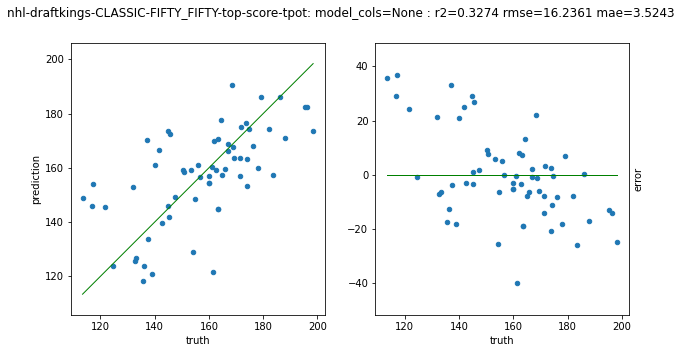

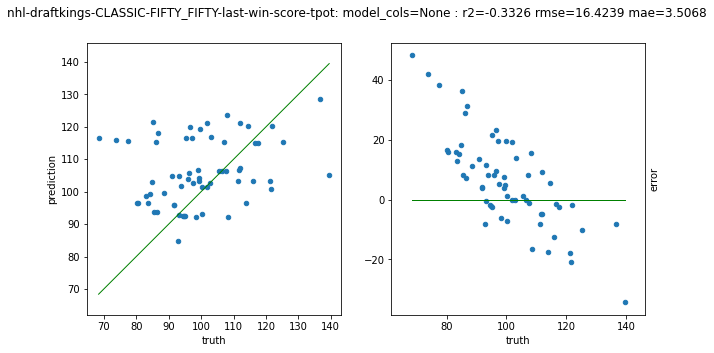

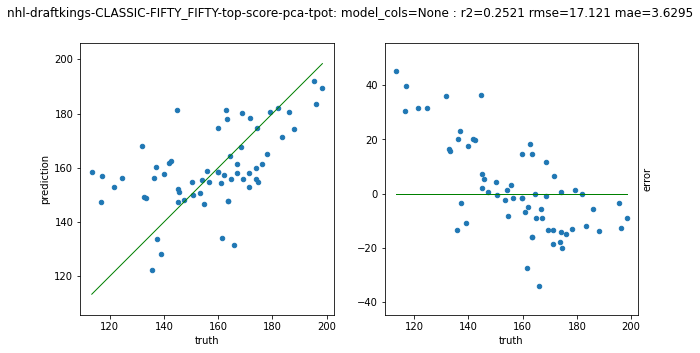

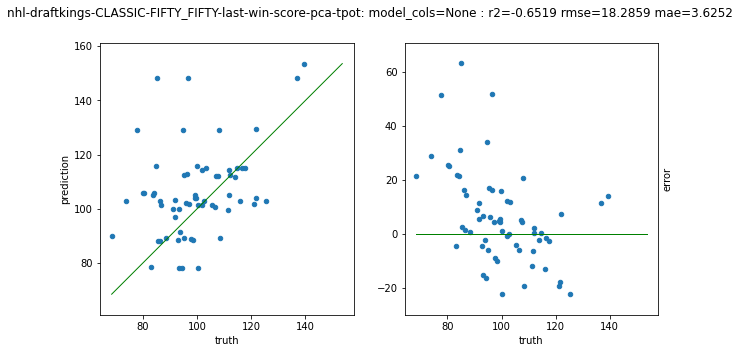

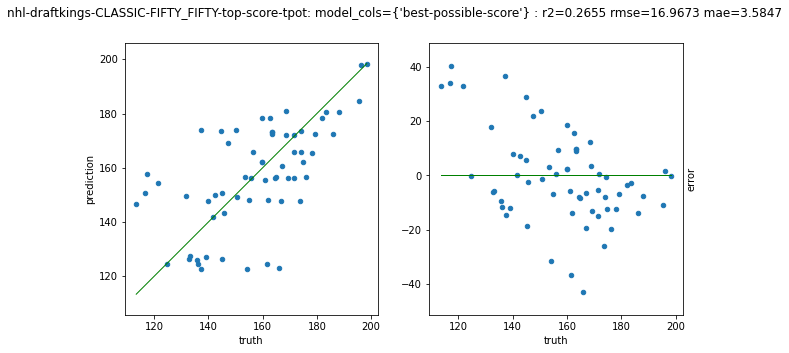

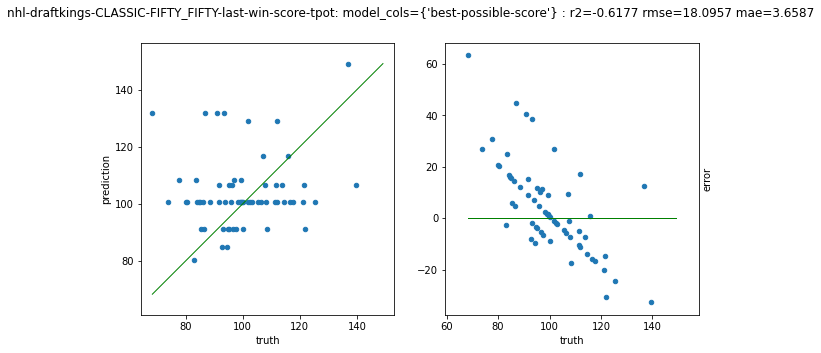

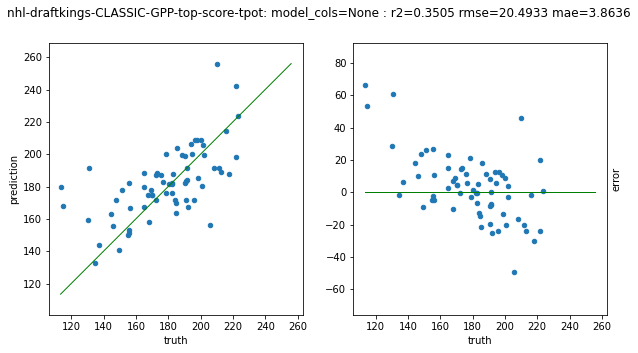

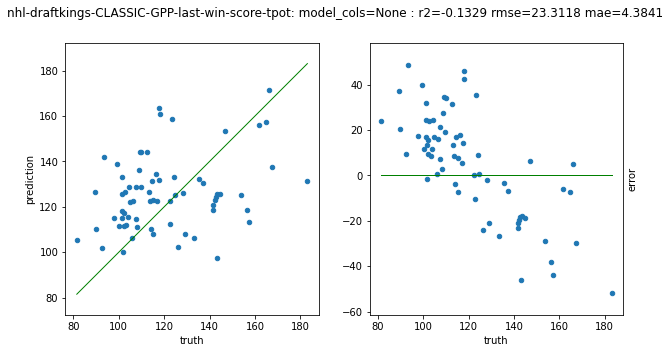

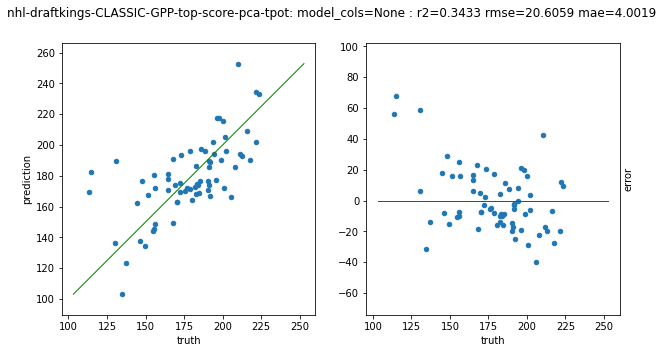

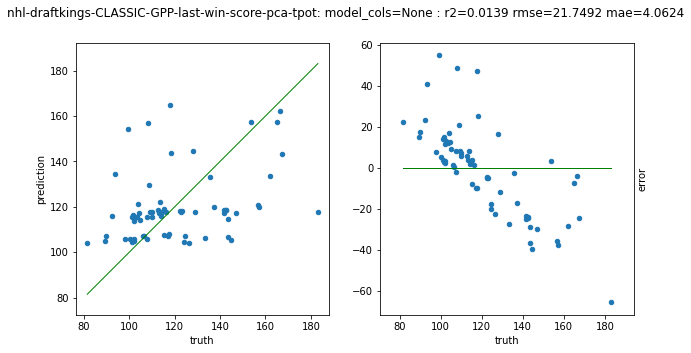

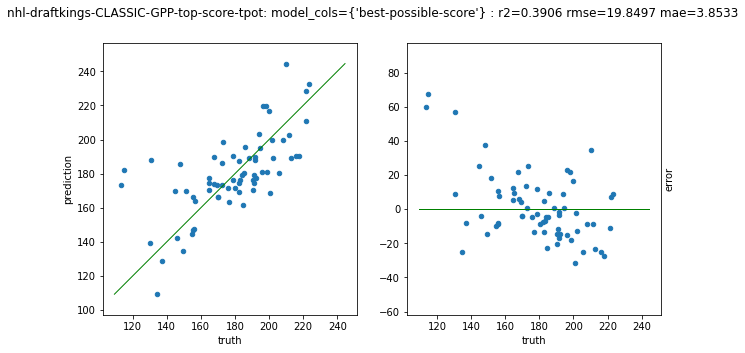

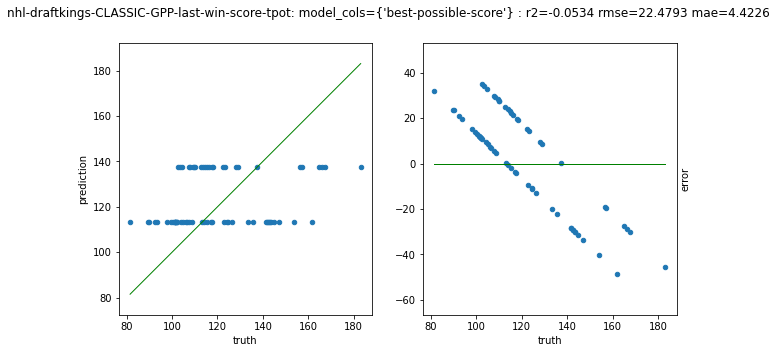

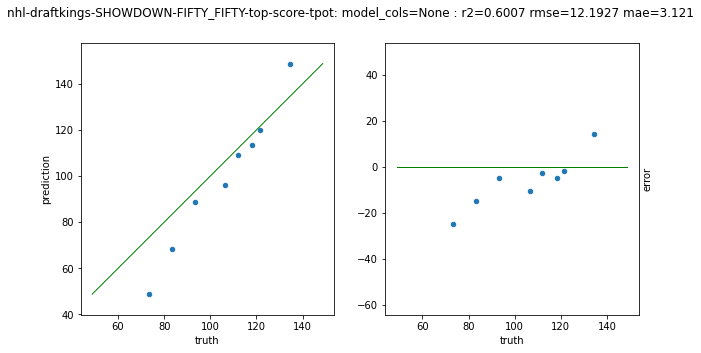

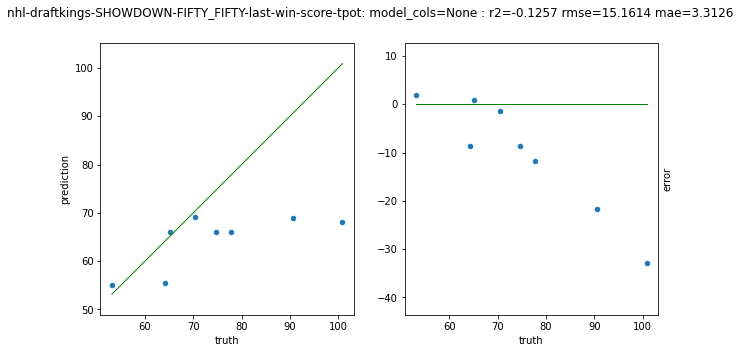

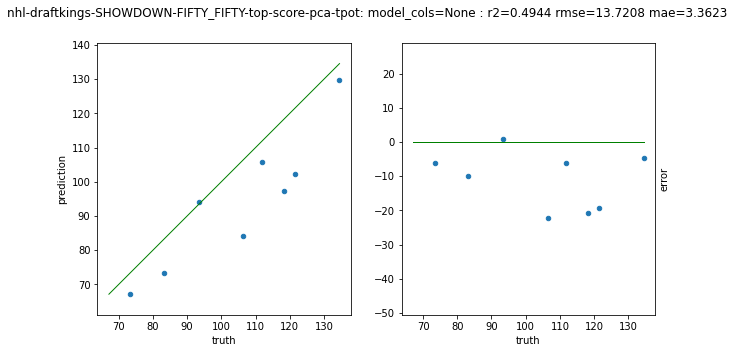

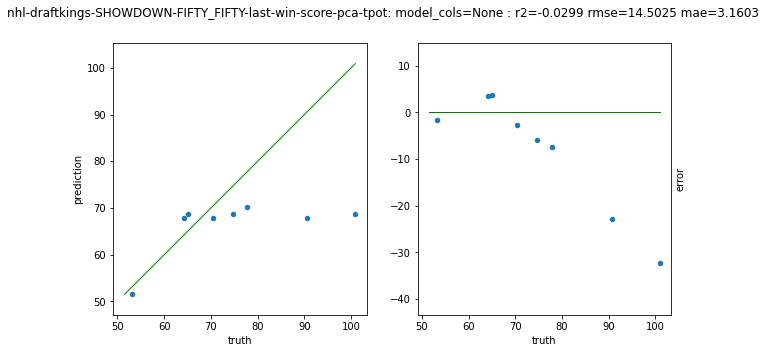

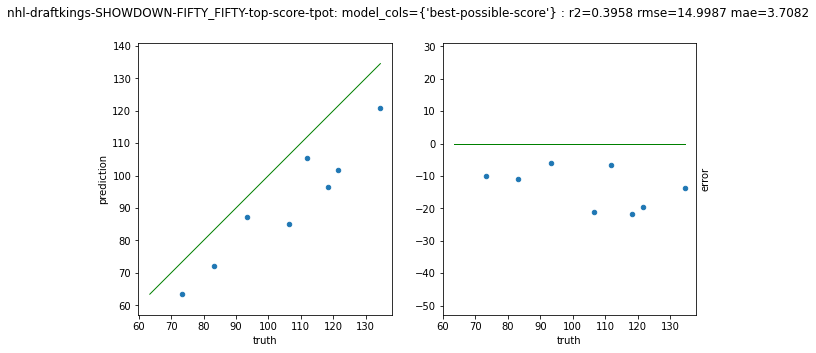

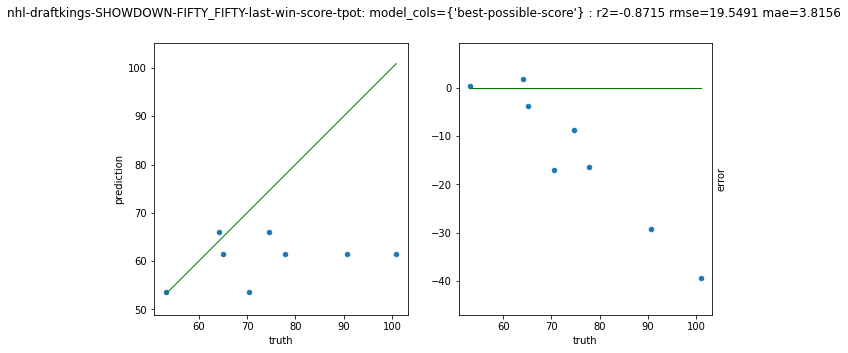

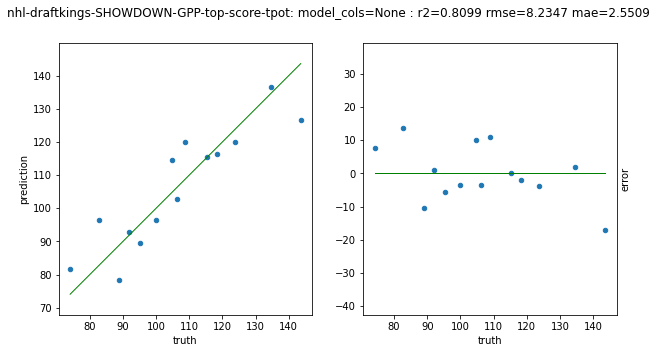

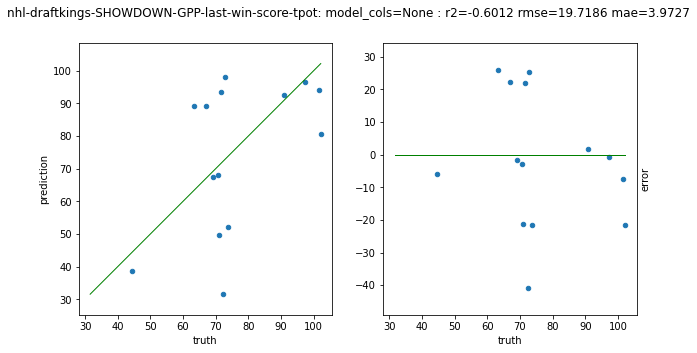

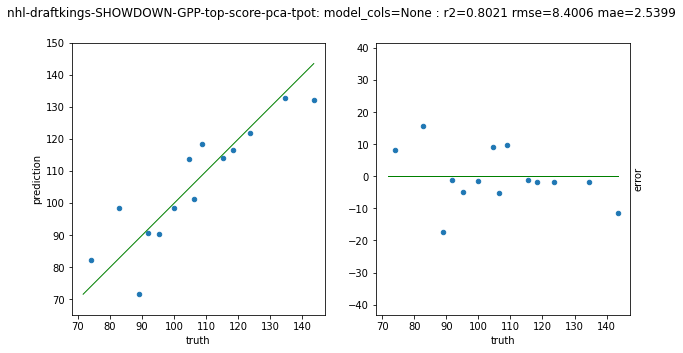

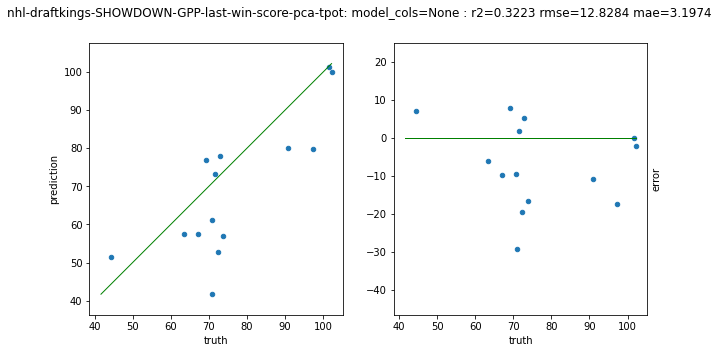

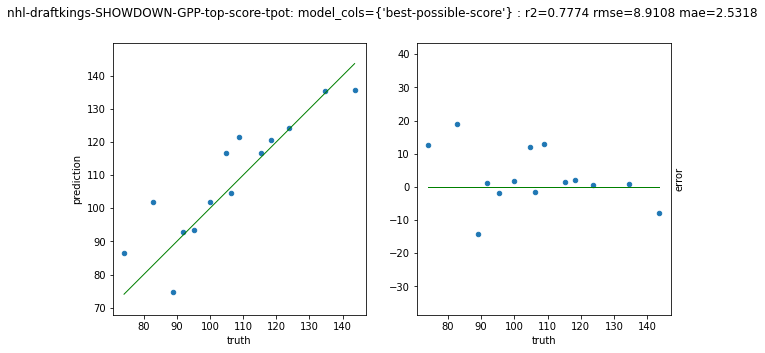

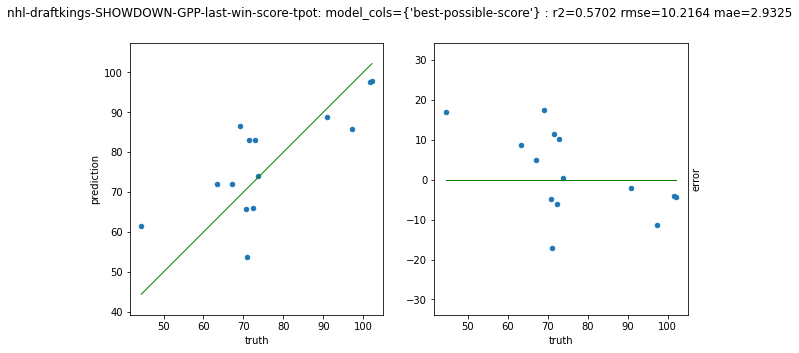

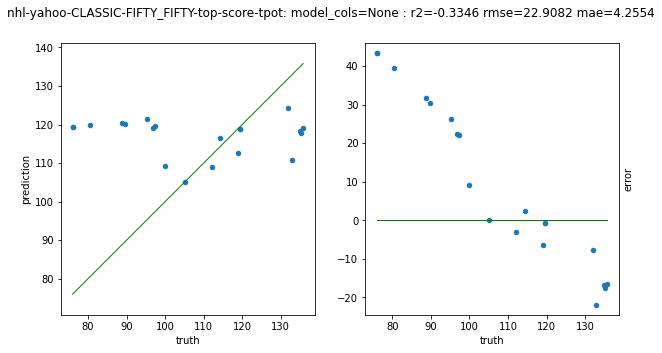

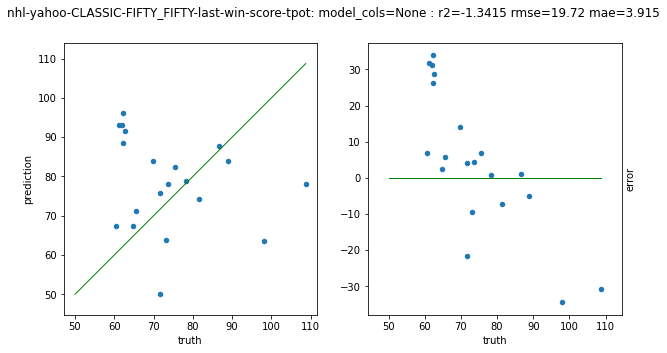

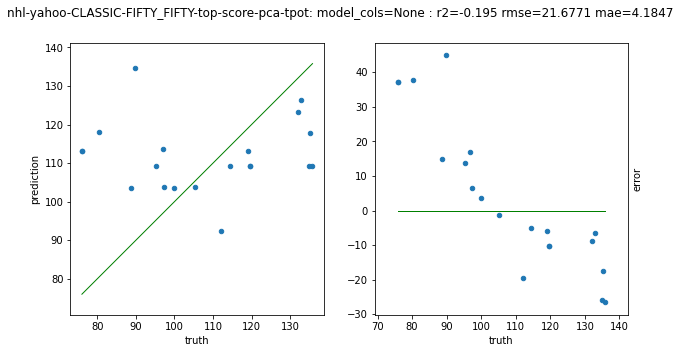

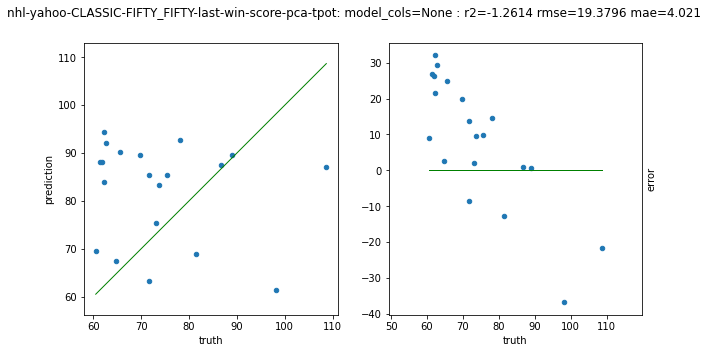

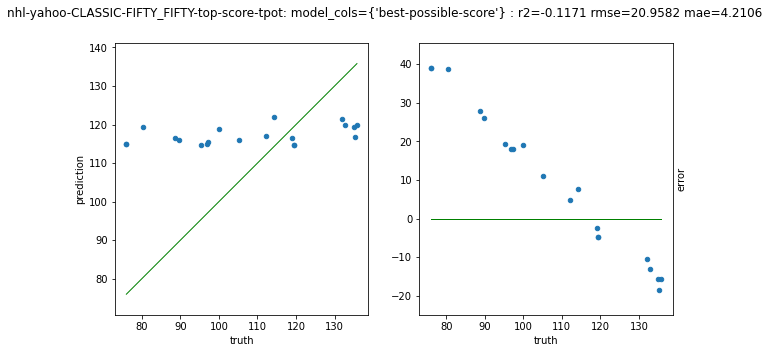

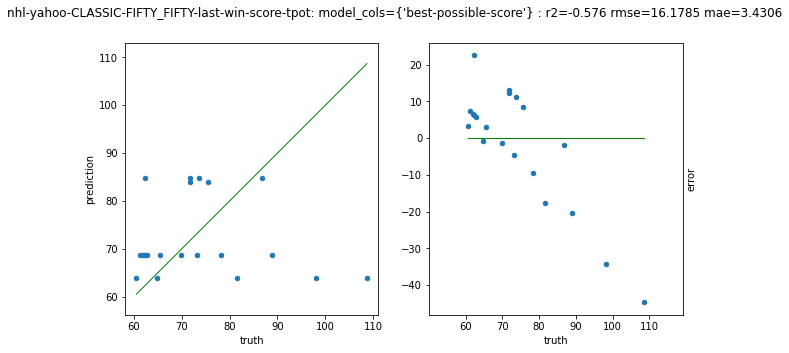

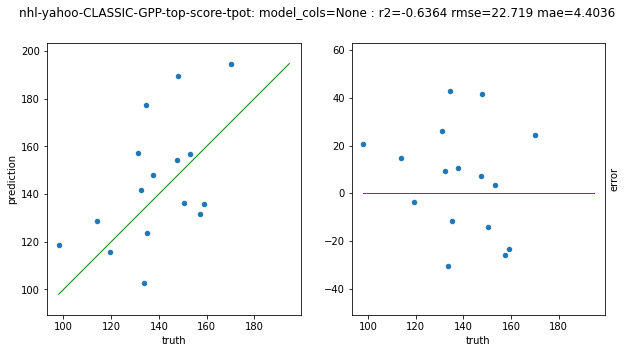

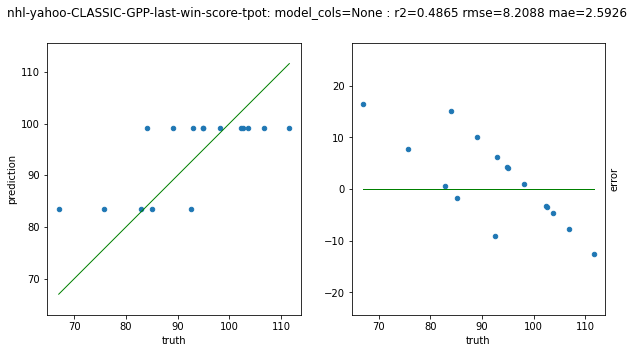

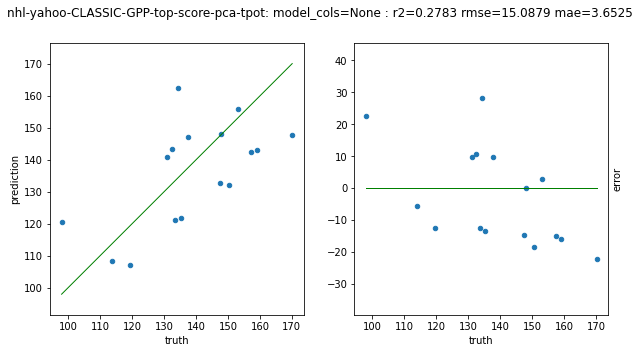

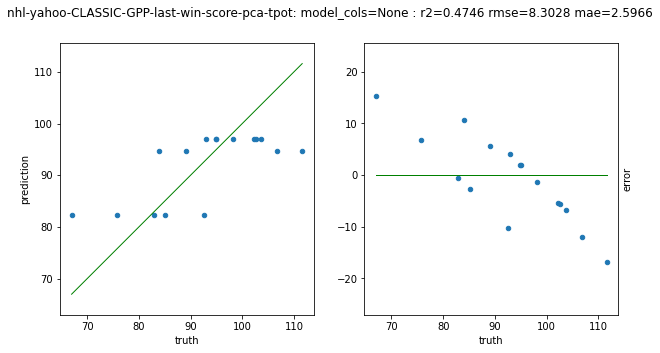

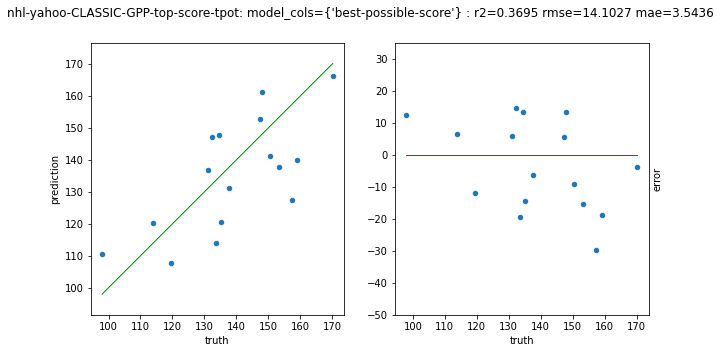

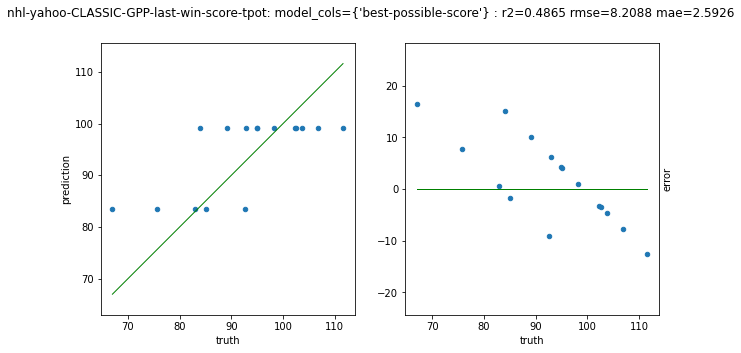

In [3]:
from fantasy_py import ContestStyle
from fantasy_py.lineup.strategy import GeneralPrizePool, FiftyFifty

# normal test run
STYLES = [ContestStyle.CLASSIC, ContestStyle.SHOWDOWN]
SPORTS = ['nhl']  # ['nhl', 'nfl', 'mlb', 'nba', 'lol']
RANDOM_SEED = 0
SERVICES = ['fanduel', 'draftkings', 'yahoo']
CONTEST_TYPES = [FiftyFifty, GeneralPrizePool]

AUTOML_PARAMS = {
#     'skautoml': {
#         'per_run_time_limit': 120,
#         'sk_overwrite': True,
#         'max_train_time': 600,
#     },
    'tpot': {
        'population_size': 100, 
        'n_jobs': 4,
        'verbosity': 2,
        # 'train_time': 600,
        'generations': 100,
        'early_stop': 10,
    }
}

models = multi_run(AUTOML_PARAMS, STYLES, SPORTS, SERVICES, CONTEST_TYPES, RANDOM_SEED)
display(models)